# Preprocessing Module — Usage Guide 

This notebook introduces the preprocessing module in ChestXsim and how to use it in practice. It shows how to:
- Use **Steps** (pipeline-ready, act on `volumeData`) vs **Functional ops** (operate on arrays).
- Build a preprocessing chain with the `Pipeline`class using `.add(...)` and `.execute(...)` methods. 
- Save intermediate outputs using the `SaveManager`.

## Overview

The **goal of preprocessing** is to transform a raw CT scan into a **patient model suitable for X-ray projection** in **Digital Chest Tomosynthesis (DCT)**.  
This is done by applying a sequence of operations (steps) that adapt the CT to the DCT geometry and convert its values into physical units.

### Main objectives
- **Virtual patient repositioning** — remove the bed, crop air, flip, or rotate to match the DCT setup.  
- **Unit transformation** — convert HU values to **linear attenuation (μ)** or **density (ρ)**.  
  When converting to density, **tissue segmentation** is required.

### Design note — “Steps are callers”

Each preprocessing **Step** implements:

`__call__(self, ct: volumeData) -> volumeData`

and returns a new `volumeData`and records parameters in `metadata.steps_outputs`. 
Thanks to this unified interface, any step can be added to a `Pipeline`and executed on a `volumeData`object. 

> **Note**:  This design makes preprocessing modular and extensible — any new step can be implemented as a simple callable class following this interface and plugged directly into the pipeline.

| Layer                                       | What it is                                                                                                                               | When to use                                                     |
| ------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Processing steps** (`steps.py`)           | High-level callable classes (e.g., `BedRemover`, `AirCropper`, `UnitConverter`) that wrap functional ops and update `MetadataContainer`. | Use individually or chained in a **`Pipeline`**.                |
| **Functional operations** (`functional.py`) | Low-level stateless array functions (crop, extend, convert). They work directly on **NumPy/CuPy** arrays and do not log metadata.        | For quick testing, prototyping, or when metadata is not needed. |


### Step-to-Function Mapping (at a glance)
| Step class        | Purpose                                                                      | Core functional calls                                                                                |
| ----------------- | ---------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| `BedRemover`      | Removes the stretcher or bed using either analytical or DL segmentation.     | `get_stretcher_mask_dl` / `get_stretcher_mask_analytical`, `remove_bed`                              |
| `AirCropper`      | Crops empty air along a specified axis.                                      | `crop_air`                                                                                           |
| `VolumeExtender`  | Extends the volume (z-axis) to match a target height or system geometry.     | `compute_extension_vals_from_target_height`, `compute_extension_vals_from_geometry`, `extend_volume` |
| `VolumeFlipper`   | Flips the volume along a chosen axis to orient the anatomy correctly.        | `flip`                                                                                               |
| `VolumeRotate`    | Rotates the volume around a defined plane (axis).                            | `rotate`                                                                                             |
| `TissueSegmenter` | Creates bone/soft-tissue masks (analytical or DL); returns stacked channels. | `get_bone_mask_dl` / `get_bone_mask_analytical`, `segment_volume`                                    |
| `UnitConverter`   | Converts HU → μ or HU → density per tissue type.                             | `compute_effective_energy`, `convert_HU_to_mu`, `convert_HU_to_density`                              |


### Pipeline execution concept
The `Pipiline`manages the ordered execution of preprocessing steps:
1. Takes an input `volumeData`
2. Applies each registered `Step` sequentially. 
3. Optionally saved inermediate outputs. 
4. Frees GPU memory between steps.
5. Returns the processed `VolumeData`.

### Using Steps Individually

This example demonstrates how to apply each preprocessing step independently to a DICOM chest CT. The final results are two processed volumes:
- one in **linear attenuation coefficients (μ)**: input to simulate monochromatic X-ray projections. 
- one in **density units (ρ)**: input to simulate polychromatic X-ray projections. 

> **Note** : The volumes processed by the steps are internally converted to  **4D array** with shape `(W, H, D, T)`, where the last dimension **T** corresponds to the tissue channel. When **T = 1**, no tissue differentiation has been applied yet — segmentation has not been performed.

In [1]:
from chestxsim.io import DicomReader
from chestxsim.preprocessing.steps import (
    BedRemover, AirCropper, VolumeExtender, TissueSegmenter, UnitConverter
)
from chestxsim.utility import plot


# --- Load DICOM case as volumeData ---
path_to_dicom = r"..\..\inputs\NODULO\S18\S20"
reader = DicomReader(convert_to_HU=True, clip_values=[-1000, 3000])
ct_data = reader.read(path_to_dicom)
print("Step 0 — DICOM volume loaded.")

# --- 1) Remove bed (analytical) — for DL: omit threshold and pass model_name ---
step_bed = BedRemover(threshold=-200, save_mask=False)
ct_bed_removed = step_bed(ct_data)
print("Step 1 — Bed removal done.")

# --- 2) Crop empty air regions along x (axis=1) ---
step_air = AirCropper(axis=1, tol=5, delta=3, channel=0)
ct_air_cropped = step_air(ct_bed_removed)
print("Step 2 — Air cropping done.")

# --- 3) Extend the volume to a target height (mm) ---
step_ext = VolumeExtender(target_height=600.0, chest_center=150)
ct_extended = step_ext(ct_air_cropped)
print("Step 3 — Volume extension done.")

# --- 4) Tissue segmentation (analytical) → stacked channels [bone, soft] ---
step_seg = TissueSegmenter(threshold=300, tissue_types=["bone", "soft"], save_masks=False)
ct_segmented = step_seg(ct_extended)
print("Step 4 — Tissue segmentation done.")

# --- 5) Convert units to linear attenuation coefficients (μ) ---
step_units_mu = UnitConverter(units="mu", mu_factor=1.0, voltage=120)
ct_mu = step_units_mu(ct_extended)
print("Step 5 — Unit conversion to μ done.")

# --- 6) Convert units to density (ρ) ---
step_units_rho = UnitConverter(
    units="density",
    tissue_types=["bone", "soft"],
    mu_factor=[1.0, 1.0],
)
ct_rho = step_units_rho(ct_segmented)
print("Step 6 — Unit conversion to ρ done.")

GPU detected: Using CuPy with 1 device(s), current device: 0
Step 0 — DICOM volume loaded.
Step 1 — Bed removal done.
Step 2 — Air cropping done.
Step 3 — Volume extension done.
Step 4 — Tissue segmentation done.
Step 5 — Unit conversion to μ done.
Step 6 — Unit conversion to ρ done.


Print the preprocessing steps log recorded in the output volume’s metadata:

In [2]:
ct_rho.metadata.show_steps()


--- Simulation Steps ---
clip_values: [-1000,3000]
BedRemover: {'bed_removed': True, 'method': 'analytical'}
AirCropper: {'axis': 1, 'crop_indices': [63, 410]}
VolumeExtender: {'extension_mm': [150.0, 105.0]}
TissueSegmenter: {'tissue_segmented': True, 'method': 'analytical', 'tissue_types': ['bone', 'soft']}
UnitConverter: {'units': 'density', 'e_eff': 47.3, 'mac_eff_water': 0.23617, 'tissue_type': ['bone', 'soft'], 'mu_factor': [1.0, 1.0]}


**Parameters variants (common patterns)**

Several preprocessing steps offer **analytical** and **deep-learning (DL)** variants, as well as flexible configuration options.  
Below are the most common cases and their corresponding parameters.

The `BedRemover` can operate in **analytical** or **DL** mode:

- **Analytical mode:** set `threshold` to a numeric value to separate patient from background (e.g., `-200`).


In [3]:
step_bed = BedRemover(threshold=-200, save_mask=False)

- **DL mode:** set `threshold=None`.  This automatically loads the pretrained model weights from:  
  `materials/models/model_BedSeg_full_model.pt`

In [4]:
step_bed_dl = BedRemover(threshold=None, save_mask=True)

> **Note:** The `save_mask` flag controls whether the computed stretcher mask is saved along with the volume.

Similar to bed removal, `TissueSegmenter` supports both analytical and DL-based segmentation:
- **Analytical mode:** use a fixed HU threshold (e.g., threshold=300).


In [5]:
step_seg = TissueSegmenter(threshold=300, tissue_types=["bone", "soft"], save_masks=False)

- **DL mode**: set `threshold=None` to use the default DL model, automatically loaded from: `materials/models/model_TissueSeg_full_model.pt`


In [6]:
step_seg_dl = TissueSegmenter(threshold=None, tissue_types=["bone", "soft"], save_masks=True)

The `VolumeExtender` allows different strategies to determine how much to extend the patient volume in the axial (z) dimension.
- **Fixed milimiter values**: manually specify the extension above and below

In [7]:
step_ext = VolumeExtender(ext_vals_mm=[30.0, 40.0])

- **Target height (mm)**: extend the volume symmetrically until reaching the desired total height, keeping the specified chest center. 

In [8]:
step_ext = VolumeExtender(target_height=420.0, chest_center=150)

- **Geometry-aware extension**: pass a `Geometry` object to automatically compute the extension needed to cover the full field of view (FOV) of the imaging system.


In [9]:
# from chestxsim.core.geometries import TomoGeom
# tomo_geo = TomoGeo(
#     detector_size=(2048, 1536),
#     pixel_size=(0.143, 0.143),
#     binning_proj=1,
#     SDD=1200.0,
#     bucky=300.0,
#     step=5.0,
#     nstep=31
# )
# step_ext = VolumeExtender(geometry=tomo_geo, chest_center=150)

The `UnitConverter` converts HU to either **linear attenuation** (μ) or **density** (ρ), with flexible controls for **effective energy** and **per-tissue scaling**.

- **Effective energy (`e_eff`) selection**
    - Provide `e_eff` **explicitly** (keV), or
    - Provide `voltage` (kVp) to **compute** `e_eff` automatically, or
    - If neither is given, it falls back to `metadata.init["voltage"]` from the input.

- **Tissue list (density mode)**
    - For `units="density"`, you **must** pass `tissue_types` matching the number/order of channels  
    (e.g., `["bone", "soft"]` for a 2-channel stacked input).

- **`mu_factor` (scaling)**
    - Scales the μ converted values **per channel**. Useful to tweak material response (e.g., **increase μ for bone**) 



In [10]:
from chestxsim.preprocessing.steps import UnitConverter

# 1) Convert HU → μ (linear attenuation)
# Automatically computes effective energy (e_eff) from tube voltage (120 kVp)
step_units_mu = UnitConverter(
    units="mu",
    voltage=120,
    mu_factor=1.0      # global scaling factor for μ
)

# 2) Convert HU → μ with explicit e_eff (55 keV)
# and a higher scaling for bone to match simulated attenuation
step_units_mu_tuned = UnitConverter(
    units="mu",
    e_eff=55,                  # fixed effective energy
    mu_factor=[2.00, 1.00]     # per-channel μ scaling (bone, soft)
)

# 3) Convert HU → ρ (density)
# Requires specifying tissue_types matching the stacked input channels
step_units_rho = UnitConverter(
    units="density",
    tissue_types=["bone", "soft"],  # per-channel tissue types
    voltage=120,                    # derive e_eff from voltage
    mu_factor=[1.0, 1.0]            # per-tissue scaling
)

**Visualize Step Intermediate Results**
- Use the `plot` function to visualize the results. The color bar reflects the current unit type (e.g., HU, μ, or ρ).
  

Step 1 — Bed Removal (analytical threshold)


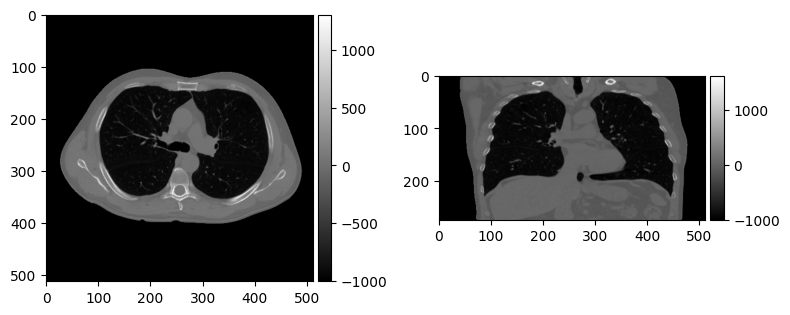

In [11]:
print("Step 1 — Bed Removal (analytical threshold)")
plot(
    ct_bed_removed.volume.get()[:, :, 100, 0].T,
    ct_bed_removed.volume.get()[:, 225, :, 0].T
)

Step 2 — Air Cropping (axis=1)


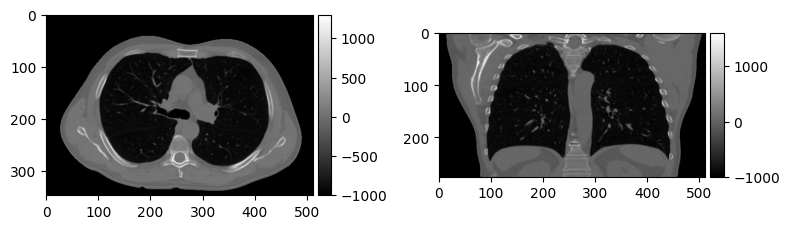

In [12]:
print("Step 2 — Air Cropping (axis=1)")
plot(
    ct_air_cropped.volume.get()[:, :, 100, 0].T,
    ct_air_cropped.volume.get()[:, 225, :, 0].T
)

Step 3 — Volume Extension (target height 600 mm)


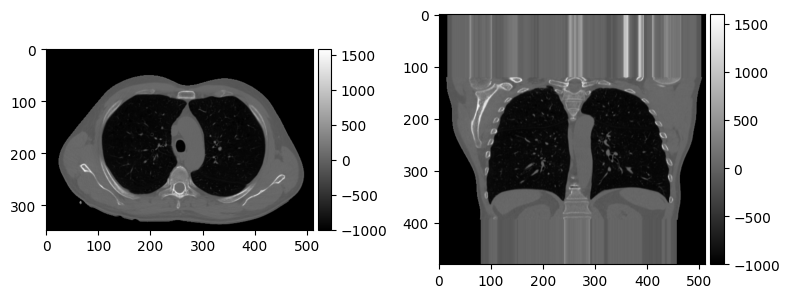

In [13]:
print("Step 3 — Volume Extension (target height 600 mm)")
plot(
    ct_extended.volume.get()[:, :, 200, 0].T,
    ct_extended.volume.get()[:, 225, :, 0].T
)


Step 4 — Tissue Segmentation (bone & soft)


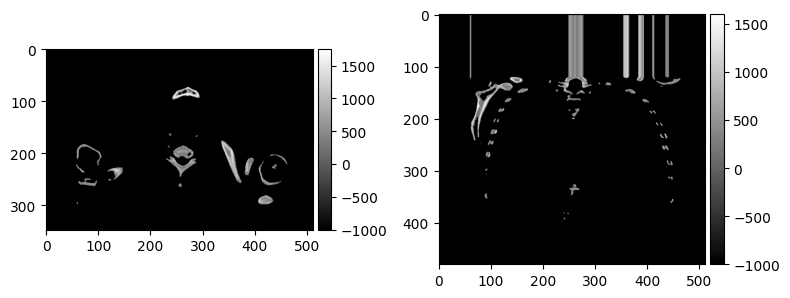

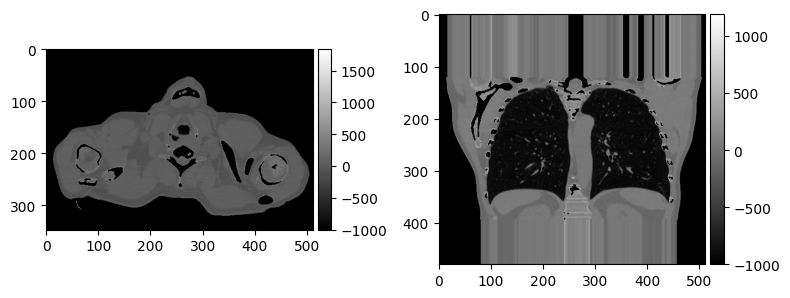

In [14]:
print("Step 4 — Tissue Segmentation (bone & soft)")
# bone channel
plot(
    ct_segmented.volume.get()[:, :, 100, 0].T,
    ct_segmented.volume.get()[:, 225, :, 0].T
)
# soft tissue channel
plot(
    ct_segmented.volume.get()[:, :, 100, 1].T,
    ct_segmented.volume.get()[:, 225, :, 1].T
)


Step 5 — Unit Conversion (HU → μ)


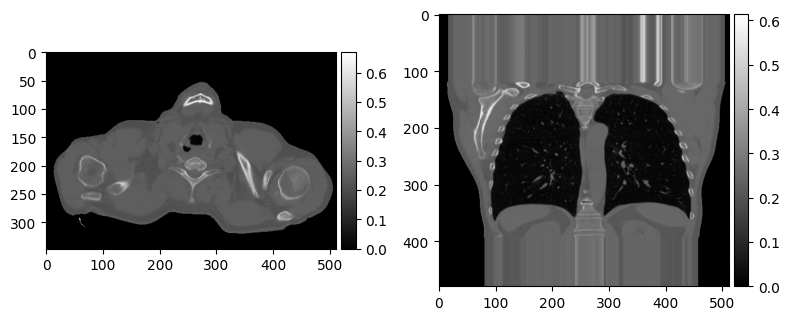

In [15]:
print("Step 5 — Unit Conversion (HU → μ)")
plot(
    ct_mu.volume.get()[:, :, 100, 0].T,
    ct_mu.volume.get()[:, 225, :, 0].T
)


Step 6 — Unit Conversion (HU → density)


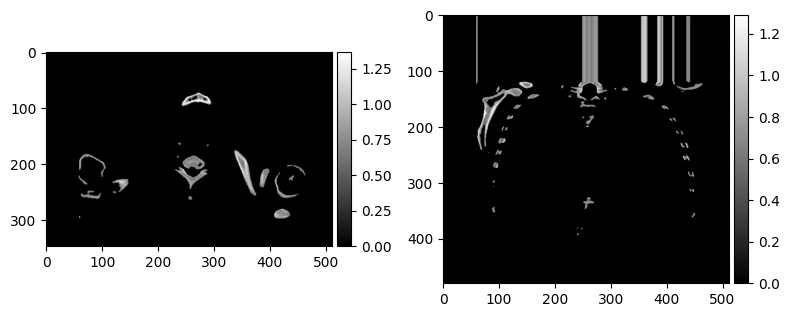

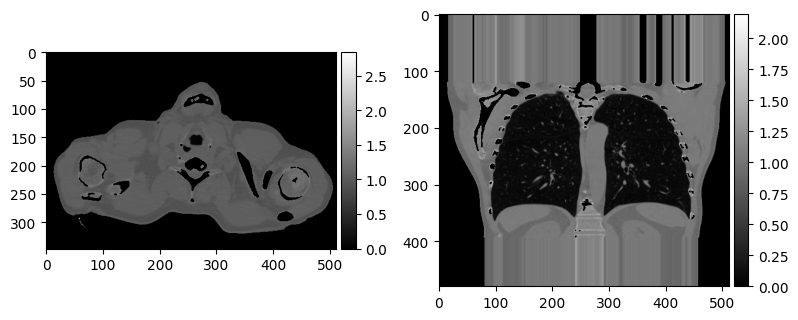

In [16]:
print("Step 6 — Unit Conversion (HU → density)")
# bone
plot(
    ct_rho.volume.get()[:, :, 100, 0].T,
    ct_rho.volume.get()[:, 225, :, 0].T
)
# soft tissue
plot(
    ct_rho.volume.get()[:, :, 100, 1].T,
    ct_rho.volume.get()[:, 225, :, 1].T
)


### Stand-Alone Functional Ops

Use the **functional layer** when you only need to perform **array-level** operations without metadata tracking or pipeline execution.  
This example shows how to load a RAW volume and apply a stand-alone functional operation. 

Original shape: (512, 512, 276)
Extended shape: (512, 512, 436)


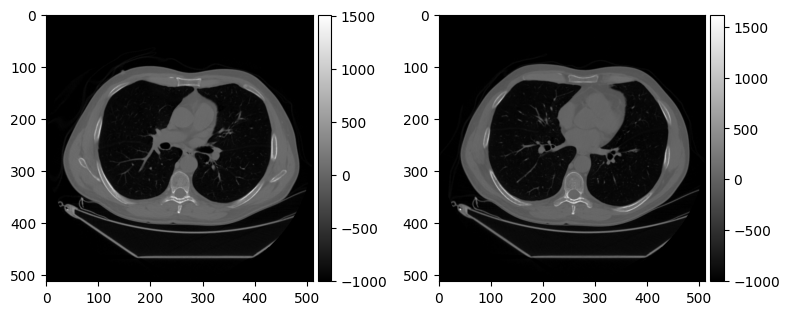

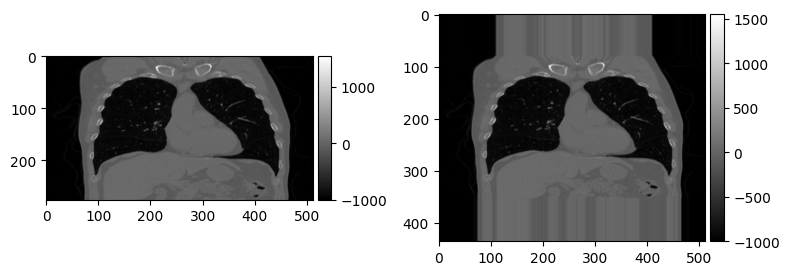

In [17]:

from chestxsim.preprocessing import functional as F
from chestxsim.io import RawReader

# --- Load RAW volume as a simple array ---
file_path   = r"D:\bhermosi\chestxsim-project\examples\volumes\NODULO_S18_S20_vx_0.84x0.84x1.25_dims_512x512x276.img"
shape       = (512, 512, 276)      # (W, H, D)
voxel_size  = (0.84, 0.84, 1.25)   # (sx, sy, sz)
dtype       = "<f4"                # or "uint16", ">i16", ...
order       = "F"                  # "F" (Fortran) or "C" (C-order)

raw_vol = RawReader.read_volume(file_path, shape, dtype, order)

# --- Apply a functional operation directly (no metadata involved) ---
extended_vol = F.extend_volume(raw_vol, ext_vals_mm=[100, 100], voxel_size=voxel_size)

print("Original shape:", raw_vol.shape)
print("Extended shape:", extended_vol.shape)

plot(raw_vol.get()[:,:, 120].T, extended_vol.get()[:,:, 220].T)
plot(raw_vol.get()[:,200, :].T, extended_vol.get()[:,200, :].T)


> **Note**: When using functional ops, parameters like `voxel_size` must be provided explicitly, unlike in `Steps` where they are automatically read from the `volumeData` metadata.

### End-to-End preprocessing with `Pipeline` (from DICOM)

The `Pipeline` class allows you to combine multiple preprocessing steps into a single, automated workflow.  
It handles the execution order, memory management, and optional saving of intermediate outputs — making it ideal for full-case preprocessing directly from DICOM input.

To run a complete preprocessing chain:

- **Initialize** a pipeline: `Pipeline(base_save_dir="results")`.  
  By default, intermediate outputs are saved under `results/` (this path can be customized).
- **Register** the configured steps with `.add(step, save= True)`.  
- **Execute** the full chain with `.execute(volumeData)`.

**How saving works (managed auromatically by `Pipeline`)**

Setting `save=True` in `.add(...)` writes the step’s output to disk via **SaveManager** (useful as checkpoints).

**Folder pattern**
`results/<step>/<spectrum>/<units>/<tissue>/<case_id>/`

where : 
- `<step>`: internal mapping (e.g., `BedRemover → CT_without_bed`, `UnitConverter → CT_converted`).
- `<spectrum>`: `polychromatic` or `monochromatic` (if applicable).
- `<units>`: `mus` or `density` after conversion.
- `<tissue>`: created for multi-channel outputs (e.g., `bone`, `soft`).
- `<case_id>`: taken from `metadata.id` (auto-incremented if a prior run exists).

Each save includes
- Binary voolume: `<case_id>.img`  
- `info.txt` (dims, voxel size, dtype ...)
- `log.txt` (step registry copied from `metadata.step_outputs`)


In this example, we reuse the steps previously configured in the [**Using Steps Individually**](#using-steps-individually) section  
and chain them together into a single preprocessing workflow. 

In [18]:
# from chestxsim.core import Pipeline 

# #  --- Initialize pipeline and define save directory ---
# prep_pipe = Pipeline(base_save_dir=r"D:\chestxsim_results")

# # --- Register configured steps ---
# prep_pipe.add(step_bed,     save=False)   # save intermediate (bed removed)
# prep_pipe.add(step_air,     save=False)   # save intermediate (air cropped)
# prep_pipe.add(step_ext,     save=False)   # no save here
# prep_pipe.add(step_units_mu,save=False)  # final save (converted to μ)

# # --- Execute pipeline ---
# out_mu = prep_pipe.execute(ct_data)

# # --- Inspect and log results ---
# print("Output μ shape:", out_mu.volume.shape)
# out_mu.metadata.show_steps()

> The plots below compare slices from the **original CT** (in HU units) and the **final preprocessed volume** (in μ units).    
Because the preprocessing steps modify the spatial extent of the data, the corresponding slice indices will not match directly.
For example, an **axial extension** of 150 mm at the top with a **voxel size of 1.25 mm** introduces a shift of roughly **120 slices**.

In [19]:
# plot(ct_data.volume.get()[:, :, 200].T, out_mu.volume.get()[:, :, 320, 0].T)
# plot(ct_data.volume.get()[:, 200, :].T, out_mu.volume.get()[:, 140, :, 0].T)

**Continue from a saved/processed result**

You can **reuse any `volumeData` output** as the **input** to a new pipeline.  
This is handy when you want to add extra steps later (e.g., a rotation) without re-running the full chain...

In [20]:
# from chestxsim.preprocessing.steps import VolumeRotate

# # Start a new, minimal pipeline from the previously processed output (out_mu)
# prep_pipe_cont = Pipeline(base_save_dir="results")
# prep_pipe_cont.add(VolumeRotate(angle=90, axis=2), save=False) 
# out_mu_rot = prep_pipe_cont.execute(out_mu)

# plot(ct_data.volume.get()[:, 200, :].T, out_mu.volume.get()[:, 140, :, 0].T,  out_mu_rot.volume.get()[:, 140, :, 0].T )

### Saving with `SaveManager`

The `SaveManager` provides two main methods for writing results to disk:

- **`save_volume()`** → saves only the **binary volume** (`.img` file).  
- **`save_step()`** → saves a complete **step output**, including the volume, `info.txt`, and `log.txt`.

In the examples below, `array` represents a NumPy/CuPy volume, and `out_mu` is a `volumeData` object produced by the preprocessing pipeline.

In [21]:
from chestxsim.io import SaveManager
import cupy as xp  # or numpy as xp

sm = SaveManager(base_save_dir="results")

# --- Save only a binary volume (.img) ---
array = xp.zeros((128, 128, 64), dtype="<f4")  # example 3D volume
sm.save_volume(volume=array, dir_path="results/test_case", file_name="test_case.img")

# --- Save a full preprocessing step (volume + metadata) ---
sm.save_step(step_units_mu.__class__.__name__, out_mu)

NameError: name 'out_mu' is not defined